In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv("../data/processed/trader_daily_metrics.csv")

In [3]:
df['pnl_momentum'] = df.groupby('account')['daily_pnl'].shift(1)

df['trade_growth'] = df.groupby('account')['trade_count'].pct_change()

df['risk_shift'] = df.groupby('account')['avg_leverage'].diff()

df['rolling_win_rate'] = (
    df.groupby('account')['win_rate']
      .rolling(3).mean()
      .reset_index(0, drop=True)
)

In [4]:
df['profit_bucket'] = pd.cut(
    df['daily_pnl'],
    bins=[-np.inf, 0, 2000, np.inf],
    labels=['Loss', 'Small Profit', 'High Profit']
)

In [5]:
df_model = df.dropna()

In [6]:
features = [
    'avg_trade_size',
    'trade_count',
    'avg_leverage',
    'pnl_volatility',
    'pnl_momentum',
    'rolling_win_rate',
    'risk_adjusted_return',
    'capital_efficiency'
]

X = df_model[features]
y = df_model['profit_bucket']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42
)

In [7]:
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42
)

model.fit(X_train, y_train)

preds = model.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

 High Profit       0.97      0.95      0.96       146
        Loss       1.00      1.00      1.00       179
Small Profit       0.96      0.98      0.97       217

    accuracy                           0.98       542
   macro avg       0.98      0.97      0.98       542
weighted avg       0.98      0.98      0.98       542



<Axes: title={'center': 'Feature Importance'}>

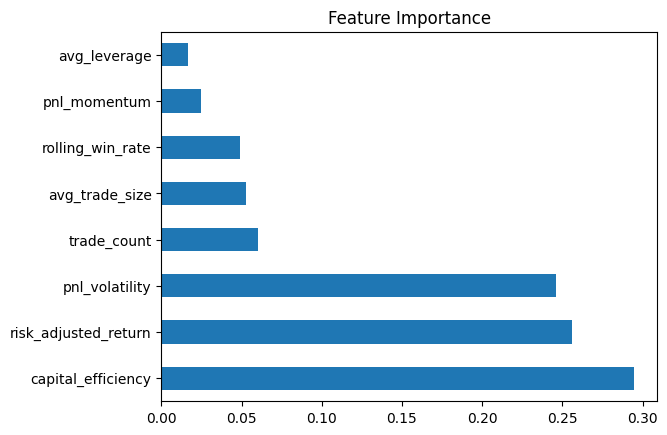

In [8]:
importances = pd.Series(
    model.feature_importances_,
    index=features
).sort_values(ascending=False)

importances.plot(kind='barh', title="Feature Importance")

In [9]:
cluster_features = df_model[
    ['avg_trade_size','trade_count','avg_leverage','win_rate','pnl_volatility']
]

cluster_scaled = StandardScaler().fit_transform(cluster_features)

In [10]:
kmeans = KMeans(n_clusters=4, random_state=42)
df_model['cluster'] = kmeans.fit_predict(cluster_scaled)

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File

In [11]:
df_model.groupby('cluster')[cluster_features.columns].mean()

,avg_trade_size,trade_count,avg_leverage,win_rate,pnl_volatility
cluster,,,,,
0,49090.515927,112.770492,1217.241128,0.475720,4310.680635
1,5153.624612,151.256189,5849.857978,0.675679,275.463026
2,5308.809736,50.983578,2595.863501,0.113824,84.670194
3,3383.526915,47.944444,421858.207923,0.622410,148.315367


In [13]:
merged_base = pd.read_csv('../data/intermediate/merged_daily_base.csv')

In [14]:
df_model = df_model.merge(
    merged_base[['date','classification']].drop_duplicates(),
    on='date',
    how='left'
)

df_model = pd.get_dummies(df_model, columns=['classification'])